In [1]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from slice_ojh import split_stock, split_mm
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
x = np.load('x_data.npy', allow_pickle = 'True')

In [3]:
# data preprocess
def prepro(data, method):
    if method == 'minmax':
        scaler = MinMaxScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'stand':
        scaler = StandardScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'robust':
        scaler = RobustScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)

### Xgboost

(557, 25) (557, 1)
(501, 25) (501, 1)
(56, 25) (56, 1)


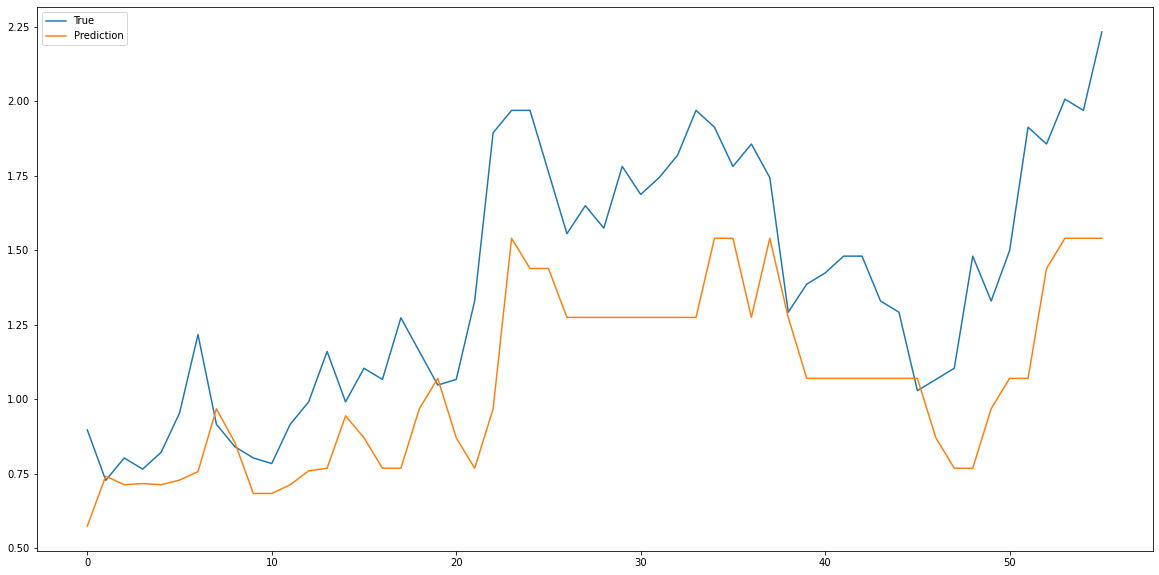

In [23]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

# close data
features, labels = split_mm(x_stand, 25, 1)
print(features.shape, labels.shape)

# split data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# training Xgboost
xgb = XGBRegressor(learning_rate=0.01, n_estimators=100, max_depth=5, random_state=3)
xgb_fit = xgb.fit(x_train, y_train)

# predict
xgb_pred = xgb.predict(x_test)

# plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(xgb_pred, label='Prediction')
ax.legend()
plt.show()

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000264A88045C8>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=5, min_child_weight=1,
                                          missing=nan,
                                          monotone_...
                                          tree_method='exact',
                                          validate_parameters=1,
                                          verbosity=None),
                   param_distributions={'co

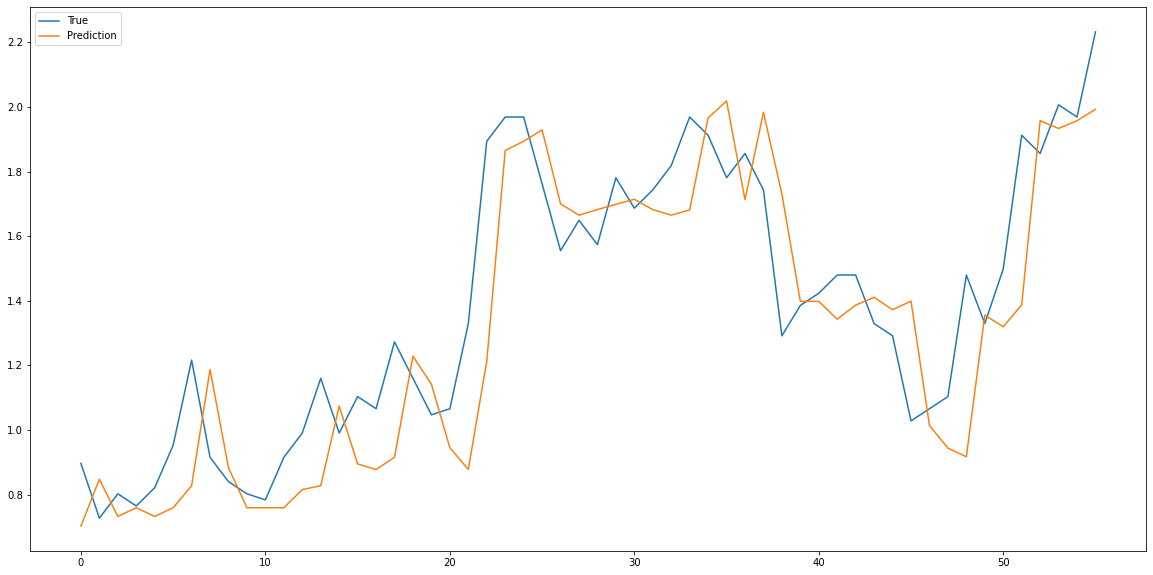

In [78]:
# Xgboost hyperparameter
params = {
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
    'n_estimators':[50,100,150,200],
    'max_depth':[3,5,7,9],
    'subsample':[0.6,0.8,1.0],
    'min_child_weight':[1,5,10],
    'gamma':[0.5,1,1.5,2],
    'max_delta_step':[1,3,5,7,9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'colsample_bytree':[0.6,0.7,0.8,0.9,1.0]}
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(xgb, params, cv=time_cv)
best_xgb = search.fit(x_train, y_train, verbose=2)
best_param = search.best_params_
print(best_xgb)
print(best_param)

best_pred = best_xgb.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

In [79]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

In [80]:
# today close
x_today = x_stand[-25:]
x_today = x_today[np.newaxis,:]
tmp = best_xgb.predict(x_today)
print(tmp)
pred_today = scaler.inverse_transform(tmp)
print(pred_today)

[2.1447916]
[59935.715]


In [81]:
# atfer 2day
x_today2 = x_stand[-24:]
x_today2 = np.append(x_today2, tmp)
x_today2 = x_today2[np.newaxis,:]
tmp2= best_xgb.predict(x_today2)
print(tmp2)
pred_today2 = scaler.inverse_transform(tmp2)
print(pred_today2)

[2.145968]
[59941.97]


### LSTM

In [82]:
# data preprocess
x_stand = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_stand[:,i] = prepro(x[:,i], 'stand')

# data slice
features, labels = split_stock(x_stand, 25, 2, 3)
print(features.shape, labels.shape)

(556, 25, 5) (556, 2)


In [83]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(500, 25, 5) (500, 2)
(56, 25, 5) (56, 2)


In [96]:
# LSTM model
def LSTM_model(drop=0.5, optimizer = 'adam'):
    inputs = Input(shape= (25,5), name = 'input')
    x = LSTM(512, activation = 'relu', name = 'hidden1', return_sequences=True)(inputs)
    x = Dropout(drop)(x)
    x = LSTM(256, activation = 'relu', name = 'hidden1')(inputs)
    x = Dropout(drop)(x)
    x = Dense(100, activation = 'relu', name = 'hidden2')(x)
    x = Dropout(drop)(x)
    #x = Dense(50, activation = 'relu', name = 'hidden3')(x)
    #x = Dropout(drop)(x)
    x = Dense(30, activation = 'relu', name = 'hidden4')(x)
    x = Dropout(drop)(x)
    outputs = Dense(2, name = 'output')(x)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
    return model

# parameter
def create_hyperparameters(): # epochs, node, acivation 추가 가능
    batches = [16, 32, 64]
    optimizers = ['rmsprop', 'adam', 'adadelta']
    dropout = [0.1, 0.2, 0.3, 0.4, 0.5]                           
    return {'batch_size' : batches, 'optimizer': optimizers, 
           'drop': dropout}

# wrapper
model = KerasRegressor(build_fn = LSTM_model, verbose = 2)

Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2419 - mse: 0.2419
Epoch 2/30
85/85 - 0s - loss: 0.2454 - mse: 0.2454
Epoch 3/30
85/85 - 0s - loss: 0.2436 - mse: 0.2436
Epoch 4/30
85/85 - 0s - loss: 0.2475 - mse: 0.2475
Epoch 5/30
85/85 - 0s - loss: 0.2408 - mse: 0.2408
Epoch 6/30
85/85 - 0s - loss: 0.2428 - mse: 0.2428
Epoch 7/30
85/85 - 0s - loss: 0.2469 - mse: 0.2469
Epoch 8/30
85/85 - 0s - loss: 0.2427 - mse: 0.2427
Epoch 9/30
85/85 - 0s - loss: 0.2452 - mse: 0.2452
Epoch 10/30
85/85 - 0s - loss: 0.2436 - mse: 0.2436
Epoch 11/30
85/85 - 0s - loss: 0.2482 - mse: 0.2482
Epoch 12/30
85/85 - 0s - loss: 0.2426 - mse: 0.2426
Epoch 13/30
85/85 - 0s - loss: 0.2429 - mse: 0.2429
Epoch 14/30
85/85 - 0s - loss: 0.2425 - mse: 0.2425
Epoch 15/30
85/85 - 0s - loss: 0.2404 - mse: 0.2404
Epoch 16/30
85/85 - 0s - loss: 0.2488 - mse: 0.2488
Epoch 17/30
85/85 - 0s - loss: 0.2415 - mse: 0.2415
Epoch 18/30
85/85 - 0s - loss: 0.2442 - mse: 0.2442
Epoch 19/30
85/85 - 0s - loss: 0.2439 - mse: 0.2439
E

Epoch 30/30
417/417 - 1s - loss: 0.9210 - mse: 0.9210
83/1 - 0s - loss: 0.4286 - mse: 0.4485
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.0934 - mse: 0.0934
Epoch 2/30
85/85 - 0s - loss: 0.0915 - mse: 0.0915
Epoch 3/30
85/85 - 0s - loss: 0.0725 - mse: 0.0725
Epoch 4/30
85/85 - 0s - loss: 0.0621 - mse: 0.0621
Epoch 5/30
85/85 - 0s - loss: 0.0494 - mse: 0.0494
Epoch 6/30
85/85 - 0s - loss: 0.0469 - mse: 0.0469
Epoch 7/30
85/85 - 0s - loss: 0.0386 - mse: 0.0386
Epoch 8/30
85/85 - 0s - loss: 0.0409 - mse: 0.0409
Epoch 9/30
85/85 - 0s - loss: 0.0389 - mse: 0.0389
Epoch 10/30
85/85 - 0s - loss: 0.0399 - mse: 0.0399
Epoch 11/30
85/85 - 0s - loss: 0.0357 - mse: 0.0357
Epoch 12/30
85/85 - 0s - loss: 0.0360 - mse: 0.0360
Epoch 13/30
85/85 - 0s - loss: 0.0354 - mse: 0.0354
Epoch 14/30
85/85 - 0s - loss: 0.0386 - mse: 0.0386
Epoch 15/30
85/85 - 0s - loss: 0.0381 - mse: 0.0381
Epoch 16/30
85/85 - 0s - loss: 0.0355 - mse: 0.0355
Epoch 17/30
85/85 - 0s - loss: 0.0376 - mse: 0.0376
Epoch 18/30


417/417 - 1s - loss: 0.0476 - mse: 0.0476
Epoch 29/30
417/417 - 1s - loss: 0.0723 - mse: 0.0723
Epoch 30/30
417/417 - 1s - loss: 0.0443 - mse: 0.0443
83/1 - 0s - loss: 0.2627 - mse: 0.4802
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.3093 - mse: 0.3093
Epoch 2/30
85/85 - 0s - loss: 0.2173 - mse: 0.2173
Epoch 3/30
85/85 - 0s - loss: 0.1340 - mse: 0.1340
Epoch 4/30
85/85 - 0s - loss: 0.1231 - mse: 0.1231
Epoch 5/30
85/85 - 0s - loss: 0.0775 - mse: 0.0775
Epoch 6/30
85/85 - 0s - loss: 0.0793 - mse: 0.0793
Epoch 7/30
85/85 - 0s - loss: 0.0741 - mse: 0.0741
Epoch 8/30
85/85 - 0s - loss: 0.0709 - mse: 0.0709
Epoch 9/30
85/85 - 0s - loss: 0.0518 - mse: 0.0518
Epoch 10/30
85/85 - 0s - loss: 0.0686 - mse: 0.0686
Epoch 11/30
85/85 - 0s - loss: 0.0781 - mse: 0.0781
Epoch 12/30
85/85 - 0s - loss: 0.0701 - mse: 0.0701
Epoch 13/30
85/85 - 0s - loss: 0.0530 - mse: 0.0530
Epoch 14/30
85/85 - 0s - loss: 0.0466 - mse: 0.0466
Epoch 15/30
85/85 - 0s - loss: 0.0489 - mse: 0.0489
Epoch 16/30
85/85 - 

Epoch 27/30
417/417 - 1s - loss: 0.0772 - mse: 0.0772
Epoch 28/30
417/417 - 1s - loss: 0.0734 - mse: 0.0734
Epoch 29/30
417/417 - 1s - loss: 0.0750 - mse: 0.0750
Epoch 30/30
417/417 - 1s - loss: 0.0690 - mse: 0.0690
83/1 - 0s - loss: 0.3163 - mse: 0.5312
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2358 - mse: 0.2358
Epoch 2/30
85/85 - 0s - loss: 0.1347 - mse: 0.1347
Epoch 3/30
85/85 - 0s - loss: 0.0681 - mse: 0.0681
Epoch 4/30
85/85 - 0s - loss: 0.0548 - mse: 0.0548
Epoch 5/30
85/85 - 0s - loss: 0.0522 - mse: 0.0522
Epoch 6/30
85/85 - 0s - loss: 0.0569 - mse: 0.0569
Epoch 7/30
85/85 - 0s - loss: 0.0500 - mse: 0.0500
Epoch 8/30
85/85 - 0s - loss: 0.0452 - mse: 0.0452
Epoch 9/30
85/85 - 0s - loss: 0.0472 - mse: 0.0472
Epoch 10/30
85/85 - 0s - loss: 0.0420 - mse: 0.0420
Epoch 11/30
85/85 - 0s - loss: 0.0439 - mse: 0.0439
Epoch 12/30
85/85 - 0s - loss: 0.0444 - mse: 0.0444
Epoch 13/30
85/85 - 0s - loss: 0.0447 - mse: 0.0447
Epoch 14/30
85/85 - 0s - loss: 0.0457 - mse: 0.0457
Epoch 

417/417 - 1s - loss: 0.0845 - mse: 0.0845
Epoch 26/30
417/417 - 1s - loss: 0.0621 - mse: 0.0621
Epoch 27/30
417/417 - 1s - loss: 0.0663 - mse: 0.0663
Epoch 28/30
417/417 - 1s - loss: 0.0644 - mse: 0.0644
Epoch 29/30
417/417 - 1s - loss: 0.0702 - mse: 0.0702
Epoch 30/30
417/417 - 1s - loss: 0.0628 - mse: 0.0628
83/1 - 0s - loss: 0.2715 - mse: 0.3738
Train on 85 samples
Epoch 1/30
85/85 - 3s - loss: 0.2666 - mse: 0.2666
Epoch 2/30
85/85 - 0s - loss: 0.1895 - mse: 0.1895
Epoch 3/30
85/85 - 0s - loss: 0.1104 - mse: 0.1104
Epoch 4/30
85/85 - 0s - loss: 0.0576 - mse: 0.0576
Epoch 5/30
85/85 - 0s - loss: 0.0716 - mse: 0.0716
Epoch 6/30
85/85 - 0s - loss: 0.0489 - mse: 0.0489
Epoch 7/30
85/85 - 0s - loss: 0.0550 - mse: 0.0550
Epoch 8/30
85/85 - 0s - loss: 0.0571 - mse: 0.0571
Epoch 9/30
85/85 - 0s - loss: 0.0536 - mse: 0.0536
Epoch 10/30
85/85 - 0s - loss: 0.0459 - mse: 0.0459
Epoch 11/30
85/85 - 0s - loss: 0.0367 - mse: 0.0367
Epoch 12/30
85/85 - 0s - loss: 0.0413 - mse: 0.0413
Epoch 13/30
85

Epoch 24/30
417/417 - 1s - loss: 0.0580 - mse: 0.0580
Epoch 25/30
417/417 - 1s - loss: 0.0576 - mse: 0.0576
Epoch 26/30
417/417 - 1s - loss: 0.0709 - mse: 0.0709
Epoch 27/30
417/417 - 1s - loss: 0.0626 - mse: 0.0626
Epoch 28/30
417/417 - 1s - loss: 0.0680 - mse: 0.0680
Epoch 29/30
417/417 - 1s - loss: 0.0547 - mse: 0.0547
Epoch 30/30
417/417 - 1s - loss: 0.0633 - mse: 0.0633
83/1 - 0s - loss: 0.4006 - mse: 0.6982
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2260 - mse: 0.2260
Epoch 2/30
85/85 - 0s - loss: 0.1081 - mse: 0.1081
Epoch 3/30
85/85 - 0s - loss: 0.0858 - mse: 0.0858
Epoch 4/30
85/85 - 0s - loss: 0.0628 - mse: 0.0628
Epoch 5/30
85/85 - 0s - loss: 0.0635 - mse: 0.0635
Epoch 6/30
85/85 - 0s - loss: 0.0626 - mse: 0.0626
Epoch 7/30
85/85 - 0s - loss: 0.0554 - mse: 0.0554
Epoch 8/30
85/85 - 0s - loss: 0.0510 - mse: 0.0510
Epoch 9/30
85/85 - 0s - loss: 0.0381 - mse: 0.0381
Epoch 10/30
85/85 - 0s - loss: 0.0492 - mse: 0.0492
Epoch 11/30
85/85 - 0s - loss: 0.0489 - mse: 0.0489


417/417 - 1s - loss: 0.1386 - mse: 0.1386
Epoch 23/30
417/417 - 1s - loss: 0.1323 - mse: 0.1323
Epoch 24/30
417/417 - 1s - loss: 0.1387 - mse: 0.1387
Epoch 25/30
417/417 - 1s - loss: 0.1720 - mse: 0.1720
Epoch 26/30
417/417 - 1s - loss: 0.1367 - mse: 0.1367
Epoch 27/30
417/417 - 1s - loss: 0.1443 - mse: 0.1443
Epoch 28/30
417/417 - 1s - loss: 0.1178 - mse: 0.1178
Epoch 29/30
417/417 - 1s - loss: 0.1301 - mse: 0.1301
Epoch 30/30
417/417 - 1s - loss: 0.1106 - mse: 0.1106
83/1 - 0s - loss: 1.0694 - mse: 1.9978
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2022 - mse: 0.2022
Epoch 2/30
85/85 - 0s - loss: 0.0897 - mse: 0.0897
Epoch 3/30
85/85 - 0s - loss: 0.0954 - mse: 0.0954
Epoch 4/30
85/85 - 0s - loss: 0.0995 - mse: 0.0995
Epoch 5/30
85/85 - 0s - loss: 0.0765 - mse: 0.0765
Epoch 6/30
85/85 - 0s - loss: 0.0780 - mse: 0.0780
Epoch 7/30
85/85 - 0s - loss: 0.0595 - mse: 0.0595
Epoch 8/30
85/85 - 0s - loss: 0.0779 - mse: 0.0779
Epoch 9/30
85/85 - 0s - loss: 0.0650 - mse: 0.0650
Epoch 10

Epoch 21/30
417/417 - 1s - loss: 0.1451 - mse: 0.1451
Epoch 22/30
417/417 - 1s - loss: 0.1387 - mse: 0.1387
Epoch 23/30
417/417 - 1s - loss: 0.1432 - mse: 0.1432
Epoch 24/30
417/417 - 1s - loss: 0.1408 - mse: 0.1408
Epoch 25/30
417/417 - 1s - loss: 0.1200 - mse: 0.1200
Epoch 26/30
417/417 - 1s - loss: 0.1341 - mse: 0.1341
Epoch 27/30
417/417 - 1s - loss: 0.1702 - mse: 0.1702
Epoch 28/30
417/417 - 1s - loss: 0.1571 - mse: 0.1571
Epoch 29/30
417/417 - 1s - loss: 0.1386 - mse: 0.1386
Epoch 30/30
417/417 - 1s - loss: 0.1297 - mse: 0.1297
83/1 - 0s - loss: 0.4570 - mse: 0.8748
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2682 - mse: 0.2682
Epoch 2/30
85/85 - 0s - loss: 0.1672 - mse: 0.1672
Epoch 3/30
85/85 - 0s - loss: 0.1268 - mse: 0.1268
Epoch 4/30
85/85 - 0s - loss: 0.1000 - mse: 0.1000
Epoch 5/30
85/85 - 0s - loss: 0.0878 - mse: 0.0878
Epoch 6/30
85/85 - 0s - loss: 0.0776 - mse: 0.0776
Epoch 7/30
85/85 - 0s - loss: 0.0702 - mse: 0.0702
Epoch 8/30
85/85 - 0s - loss: 0.0834 - mse: 

417/417 - 1s - loss: 0.1019 - mse: 0.1019
Epoch 20/30
417/417 - 1s - loss: 0.1154 - mse: 0.1154
Epoch 21/30
417/417 - 1s - loss: 0.1178 - mse: 0.1178
Epoch 22/30
417/417 - 1s - loss: 0.0833 - mse: 0.0833
Epoch 23/30
417/417 - 1s - loss: 0.1102 - mse: 0.1102
Epoch 24/30
417/417 - 1s - loss: 0.1254 - mse: 0.1254
Epoch 25/30
417/417 - 1s - loss: 0.1072 - mse: 0.1072
Epoch 26/30
417/417 - 1s - loss: 0.0948 - mse: 0.0948
Epoch 27/30
417/417 - 1s - loss: 0.1139 - mse: 0.1139
Epoch 28/30
417/417 - 1s - loss: 0.1142 - mse: 0.1142
Epoch 29/30
417/417 - 1s - loss: 0.1057 - mse: 0.1057
Epoch 30/30
417/417 - 1s - loss: 0.0894 - mse: 0.0894
83/1 - 0s - loss: 0.1396 - mse: 0.2555
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2307 - mse: 0.2307
Epoch 2/30
85/85 - 0s - loss: 0.1522 - mse: 0.1522
Epoch 3/30
85/85 - 0s - loss: 0.1337 - mse: 0.1337
Epoch 4/30
85/85 - 0s - loss: 0.0927 - mse: 0.0927
Epoch 5/30
85/85 - 0s - loss: 0.1004 - mse: 0.1004
Epoch 6/30
85/85 - 0s - loss: 0.0883 - mse: 0.0883

Epoch 18/30
417/417 - 1s - loss: 0.1886 - mse: 0.1886
Epoch 19/30
417/417 - 1s - loss: 0.2002 - mse: 0.2002
Epoch 20/30
417/417 - 1s - loss: 0.1735 - mse: 0.1735
Epoch 21/30
417/417 - 1s - loss: 0.2062 - mse: 0.2062
Epoch 22/30
417/417 - 1s - loss: 0.1639 - mse: 0.1639
Epoch 23/30
417/417 - 1s - loss: 0.1634 - mse: 0.1634
Epoch 24/30
417/417 - 1s - loss: 0.1827 - mse: 0.1827
Epoch 25/30
417/417 - 1s - loss: 0.1757 - mse: 0.1757
Epoch 26/30
417/417 - 1s - loss: 0.1585 - mse: 0.1585
Epoch 27/30
417/417 - 1s - loss: 0.1549 - mse: 0.1549
Epoch 28/30
417/417 - 1s - loss: 0.1482 - mse: 0.1482
Epoch 29/30
417/417 - 1s - loss: 0.1688 - mse: 0.1688
Epoch 30/30
417/417 - 1s - loss: 0.1540 - mse: 0.1540
83/1 - 0s - loss: 0.4350 - mse: 0.6291
Train on 85 samples
Epoch 1/30
85/85 - 1s - loss: 0.2106 - mse: 0.2106
Epoch 2/30
85/85 - 0s - loss: 0.3262 - mse: 0.3262
Epoch 3/30
85/85 - 0s - loss: 0.0883 - mse: 0.0883
Epoch 4/30
85/85 - 0s - loss: 0.0596 - mse: 0.0596
Epoch 5/30
85/85 - 0s - loss: 0.058

417/417 - 1s - loss: 0.1155 - mse: 0.1155
Epoch 17/30
417/417 - 1s - loss: 0.1158 - mse: 0.1158
Epoch 18/30
417/417 - 1s - loss: 0.1043 - mse: 0.1043
Epoch 19/30
417/417 - 1s - loss: 0.1171 - mse: 0.1171
Epoch 20/30
417/417 - 1s - loss: 0.1083 - mse: 0.1083
Epoch 21/30
417/417 - 1s - loss: 0.1018 - mse: 0.1018
Epoch 22/30
417/417 - 1s - loss: 0.0931 - mse: 0.0931
Epoch 23/30
417/417 - 1s - loss: 0.1043 - mse: 0.1043
Epoch 24/30
417/417 - 1s - loss: 0.0986 - mse: 0.0986
Epoch 25/30
417/417 - 1s - loss: 0.1150 - mse: 0.1150
Epoch 26/30
417/417 - 1s - loss: 0.0941 - mse: 0.0941
Epoch 27/30
417/417 - 1s - loss: 0.1032 - mse: 0.1032
Epoch 28/30
417/417 - 1s - loss: 0.1032 - mse: 0.1032
Epoch 29/30
417/417 - 1s - loss: 0.1034 - mse: 0.1034
Epoch 30/30
417/417 - 1s - loss: 0.0896 - mse: 0.0896
83/1 - 0s - loss: 415.8287 - mse: 830.5842
Train on 500 samples
Epoch 1/30
500/500 - 2s - loss: 0.4071 - mse: 0.4071
Epoch 2/30
500/500 - 1s - loss: 0.1334 - mse: 0.1334
Epoch 3/30
500/500 - 1s - loss: 

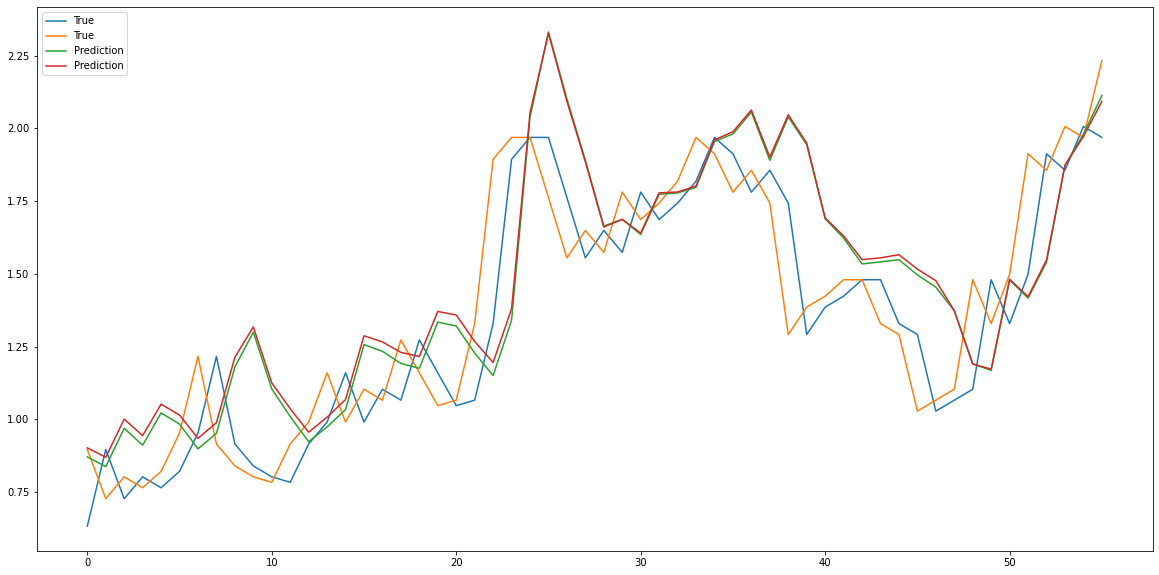

In [97]:
hyperparameters = create_hyperparameters()
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(model, hyperparameters, cv = time_cv)

best_LSTM = search.fit(x_train, y_train, epochs=30, verbose=2)
best_param = search.best_params_
print(best_LSTM)
print(best_param)

best_pred = best_LSTM.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

In [98]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)

# today close
x_today = x_stand[-25:,:]
x_today = x_today[np.newaxis,:]
pred_today = best_LSTM.predict(x_today)
print(pred_today)
pred_today = pred_today[np.newaxis]
pred_today = scaler.inverse_transform(pred_today)
print(pred_today)

1/1 - 0s
[2.131949  2.1168685]
[[59867.43  59787.246]]


### ARIMA

In [14]:
samsung = pd.read_csv('samsung0915.csv')
samsung = samsung[::-1]
samsung = samsung.drop(['시가','고가','저가','거래량'], axis=1)
samsung['종가'] = samsung['종가'].map(lambda x: int(re.sub(r',', '', x)))
samsung.reset_index(drop=True, inplace=True)
samsung.columns = ['date', 'close']

samsung['date'] = pd.to_datetime(samsung.date, format='%Y-%m-%d')
samsung = samsung.set_index('date')
print(samsung.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582 entries, 2018-05-04 to 2020-09-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   582 non-null    int64
dtypes: int64(1)
memory usage: 9.1 KB
None


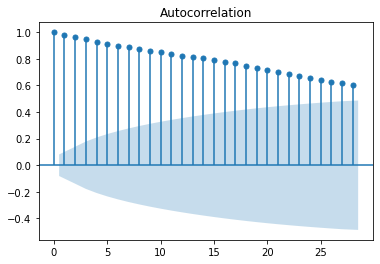

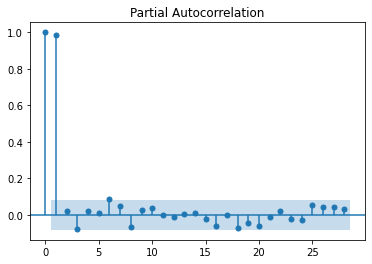

In [15]:
plot_acf(samsung) # ACF plot
plot_pacf(samsung) # PACF plot
plt.show()

In [16]:
y = samsung['close']
y_1diff = samsung.diff().dropna()['close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -1.5481
원 데이터 p-value :  0.5096
1차 차분 ADF Statistic : -15.5576
1차 차분 p-value :  0.0000


In [17]:
model = ARIMA(samsung, order=(1,1,0)) # freq='D'
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  581
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4749.899
Method:                       css-mle   S.D. of innovations            859.582
Date:                Mon, 14 Sep 2020   AIC                           9505.798
Time:                        20:52:19   BIC                           9518.892
Sample:                             1   HQIC                          9510.902
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.5627     35.365      0.412      0.680     -54.752      83.877
ar.L1.D.close    -0.0084      0.042     -0.202      0.840      -0.090       0.073
                                    Root

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [18]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(2):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([60402.92008171]), array([60417.62084936])]

In [19]:
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(samsung, [3,3,3])
result

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

,order,AIC
25,p2 d2 q1,9494.535329
7,p0 d2 q1,9495.224318
26,p2 d2 q2,9496.248273
16,p1 d2 q1,9497.173136
8,p0 d2 q2,9497.180969
17,p1 d2 q2,9497.302612
5,p0 d1 q2,9502.847493
21,p2 d1 q0,9503.102805
3,p0 d1 q0,9503.838582
14,p1 d1 q2,9504.680329


In [20]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(2):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([60491.33046294]), array([60585.13602716])]

In [21]:
#samsung.index[-1] + pd.Timedelta(days=1)

In [99]:
!jupyter nbconvert --to script 0915_stock_predict.ipynb

[NbConvertApp] Converting notebook 0915_stock_predict.ipynb to script
[NbConvertApp] Writing 8928 bytes to 0915_stock_predict.py
